<h2>1. IMPORT NECESSARY LIBRARIES</h2>

In [2]:
import numpy as np 
import pandas as pd
import random

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score
%matplotlib inline


from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression

from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import tree
from sklearn.model_selection import KFold
from sklearn.linear_model import LassoCV
from sklearn.feature_selection import RFE
from sklearn.svm import SVR
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import plot_confusion_matrix
from sklearn.cluster import KMeans

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation,Dropout
from tensorflow.keras.callbacks import EarlyStopping

<h2>2. READ THE FILE AND CLEAN IT UP</h2>

In [3]:
#messy data file

df = pd.DataFrame(columns = range(25))

file = open('/Users/mahima.sharma/Downloads/Chronic_Kidney_Disease/chronic_kidney_disease.arff')
line_list = file.readlines()

columns_list = []
index = 0

for line in line_list:
    
    #remove all leading and trailing whitespaces
    line =  line.strip()
    
    #process column names from the file and put into a list
    if(line[0:10] == '@attribute'):
        line_split = line.split()
        columns_list.append(line_split[1][1:len(line_split[1]) - 1])
        
    #process records from the file  
    else:
        line = line.replace('\t', '')
        line = line.replace(' ', '')
        line_split = line.split(',')
        
        #edge case records with multiple extra commas 
        if(len(line_split) != 25):
            for val in line_split:
                if val == '':
                    line_split.remove(val)

        if len(line_split) == 25:
            df.loc[index] = line_split
            index += 1

In [4]:
df.columns = columns_list

<h3>3. PRELIMINARY DATA EXPLORATION OF DATASET</h3>

    >Goals for doing exploratory data analysis:

    >Develop understanding of the relationship(s) between variables   
    >Extract important variables and leave behind useless variables
    >Identify outliers, missing values, or human error

In [5]:
df.head()

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,pcv,wbcc,rbcc,htn,dm,cad,appet,pe,ane,class
0,48,80,1.020,1,0,?,normal,notpresent,notpresent,121,...,44,7800,5.2,yes,yes,no,good,no,no,ckd
1,7,50,1.020,4,0,?,normal,notpresent,notpresent,?,...,38,6000,?,no,no,no,good,no,no,ckd
2,62,80,1.010,2,3,normal,normal,notpresent,notpresent,423,...,31,7500,?,no,yes,no,poor,no,yes,ckd
3,48,70,1.005,4,0,normal,abnormal,present,notpresent,117,...,32,6700,3.9,yes,no,no,poor,yes,yes,ckd
4,51,80,1.010,2,0,normal,normal,notpresent,notpresent,106,...,35,7300,4.6,no,no,no,good,no,no,ckd


In [6]:
df.shape

(400, 25)

    >The dataset has 400 rows and 25 columns (24 attributes + 1 target class)

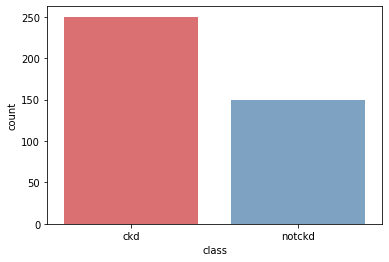

In [7]:
sns.countplot(df['class'], palette = 'Set1', alpha = 0.7)

    >The target class is slightly skewed, with a ratio of 0.625 : 0.375

In [8]:
df = df.replace('?', np.nan)

In [9]:
df.isnull().sum()

age        9
bp        12
sg        47
al        46
su        49
rbc      152
pc        65
pcc        4
ba         4
bgr       44
bu        19
sc        17
sod       87
pot       88
hemo      52
pcv       71
wbcc     106
rbcc     131
htn        2
dm         2
cad        2
appet      1
pe         1
ane        1
class      0
dtype: int64

    >The number of missing values in each column

In [10]:
100 * df.isnull().sum()/len(df)

age       2.25
bp        3.00
sg       11.75
al       11.50
su       12.25
rbc      38.00
pc       16.25
pcc       1.00
ba        1.00
bgr      11.00
bu        4.75
sc        4.25
sod      21.75
pot      22.00
hemo     13.00
pcv      17.75
wbcc     26.50
rbcc     32.75
htn       0.50
dm        0.50
cad       0.50
appet     0.25
pe        0.25
ane       0.25
class     0.00
dtype: float64

    >Percent of missing values in column

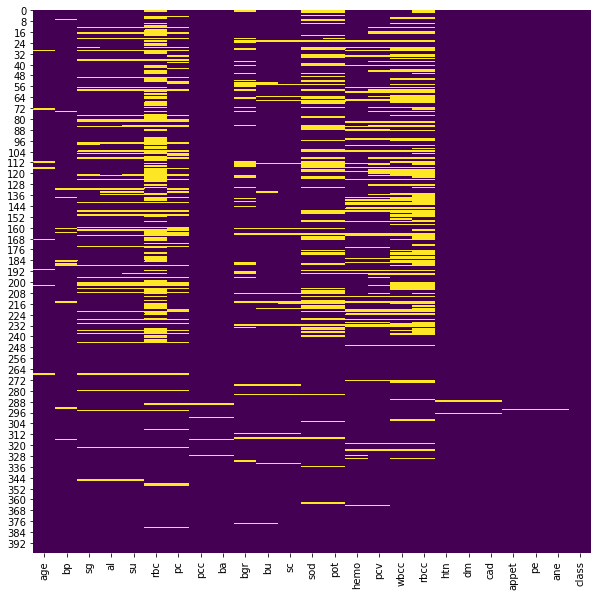

In [11]:
plt.figure(figsize = (10,10))
sns.heatmap(df.isnull(), cbar=False, cmap = 'viridis')

    >Yellow parts are missing values. We can see that rbc and rbcc are missing the most values

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400 entries, 0 to 399
Data columns (total 25 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   age     391 non-null    object
 1   bp      388 non-null    object
 2   sg      353 non-null    object
 3   al      354 non-null    object
 4   su      351 non-null    object
 5   rbc     248 non-null    object
 6   pc      335 non-null    object
 7   pcc     396 non-null    object
 8   ba      396 non-null    object
 9   bgr     356 non-null    object
 10  bu      381 non-null    object
 11  sc      383 non-null    object
 12  sod     313 non-null    object
 13  pot     312 non-null    object
 14  hemo    348 non-null    object
 15  pcv     329 non-null    object
 16  wbcc    294 non-null    object
 17  rbcc    269 non-null    object
 18  htn     398 non-null    object
 19  dm      398 non-null    object
 20  cad     398 non-null    object
 21  appet   399 non-null    object
 22  pe      399 non-null    ob

In [13]:
#Split data right away to avoid potential data leakage while scaling etc

from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df, test_size=0.33, random_state=101, shuffle = True)

df_train.reset_index(inplace = True)
df_train = df_train.drop('index', axis = 1)

df_test.reset_index(inplace = True)
df_test = df_test.drop('index', axis = 1)

<h3>DATA EXPLORATION OF TRAINING DATASET</h3>

In [14]:
df_train.head()

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,pcv,wbcc,rbcc,htn,dm,cad,appet,pe,ane,class
0,35,80,1.020,0,0,normal,normal,notpresent,notpresent,104,...,45,4300,5.2,no,no,no,good,no,no,notckd
1,63,100,1.010,2,2,normal,normal,notpresent,present,280,...,40,9800,4.2,yes,no,yes,good,no,no,ckd
2,70,60,NaN,NaN,NaN,NaN,NaN,notpresent,notpresent,120,...,43,4500,4.9,no,no,no,good,no,no,notckd
3,64,70,1.020,0,0,normal,normal,notpresent,notpresent,97,...,49,6400,4.8,no,no,no,good,no,no,notckd
4,70,80,NaN,NaN,NaN,NaN,NaN,notpresent,notpresent,158,...,30,NaN,NaN,yes,no,no,good,yes,no,ckd


In [15]:
df_train.shape

(268, 25)

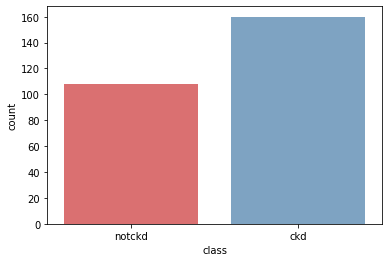

In [16]:
sns.countplot(df_train['class'], palette = 'Set1', alpha = 0.7)

In [17]:
df_train = df_train.replace('?', np.nan)

In [18]:
df_train.isnull().sum()

age       6
bp        7
sg       30
al       29
su       31
rbc      98
pc       40
pcc       3
ba        3
bgr      27
bu       13
sc       11
sod      53
pot      54
hemo     29
pcv      38
wbcc     64
rbcc     79
htn       2
dm        2
cad       2
appet     1
pe        1
ane       1
class     0
dtype: int64

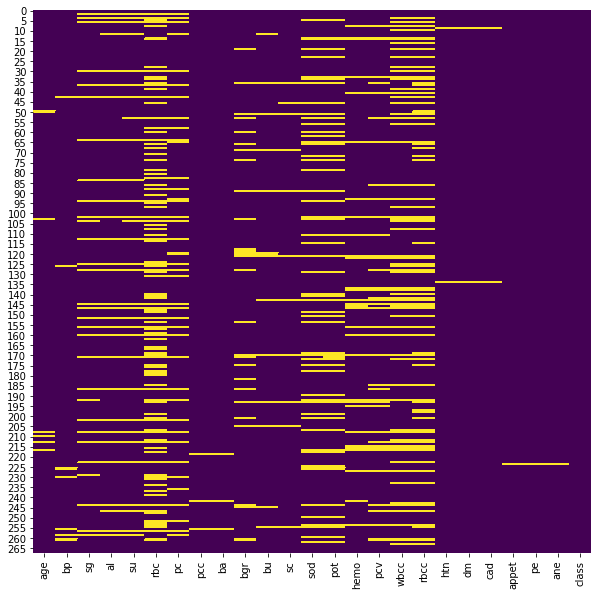

In [19]:
plt.figure(figsize = (10,10))
sns.heatmap(df_train.isnull(), cbar=False, cmap = 'viridis')

<h3>3A. EXPLORATION OF NUMERICAL ATTRIBUTES</h3>

In [20]:
df_train.columns

Index(['age', 'bp', 'sg', 'al', 'su', 'rbc', 'pc', 'pcc', 'ba', 'bgr', 'bu',
       'sc', 'sod', 'pot', 'hemo', 'pcv', 'wbcc', 'rbcc', 'htn', 'dm', 'cad',
       'appet', 'pe', 'ane', 'class'],
      dtype='object')

In [21]:
numeric_columns = ['age','bp', 'bgr','bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wbcc', 'rbcc']

for column in numeric_columns:
    df_train[column] = pd.to_numeric(df_train[column], errors = 'ignore')

In [22]:
df_train['class'] = df_train['class'].map({'ckd' : 0, 'notckd' : 1})

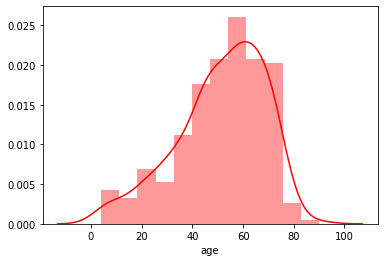

In [23]:
sns.distplot(df_train['age'], color = 'r')

    >We can see that the age distributation is a bit skewed towards older ages

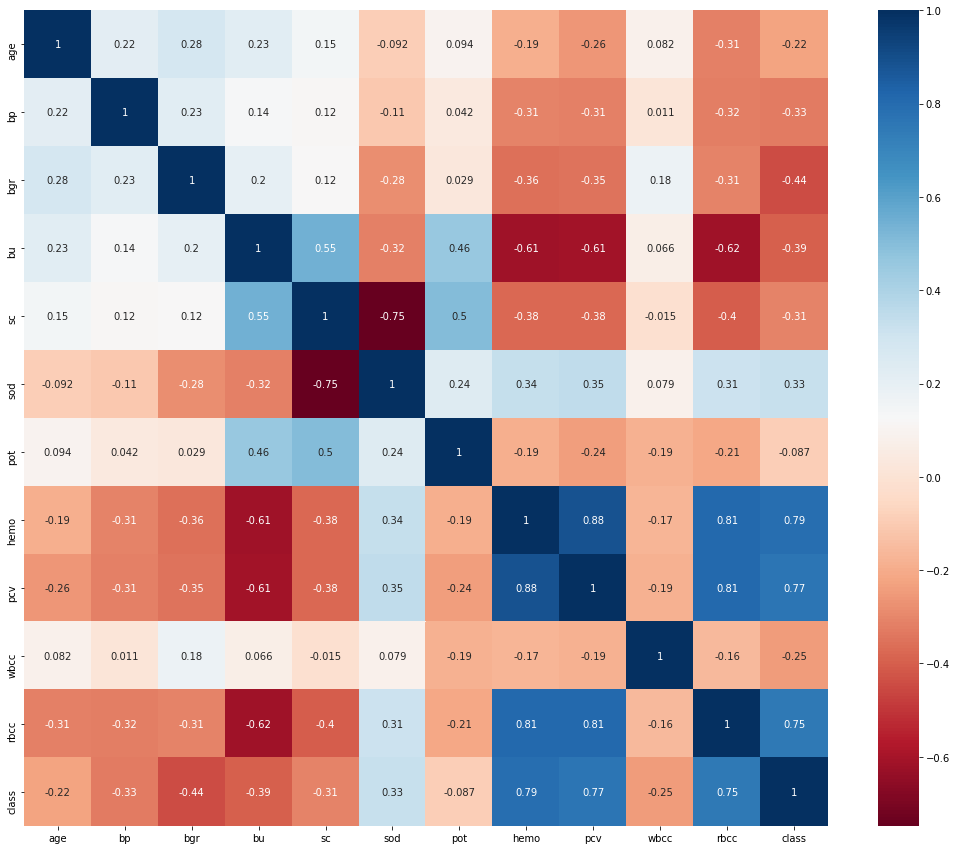

In [24]:
plt.figure(figsize = (18,15))
sns.heatmap(df_train.corr(), annot = True, cmap = 'RdBu')

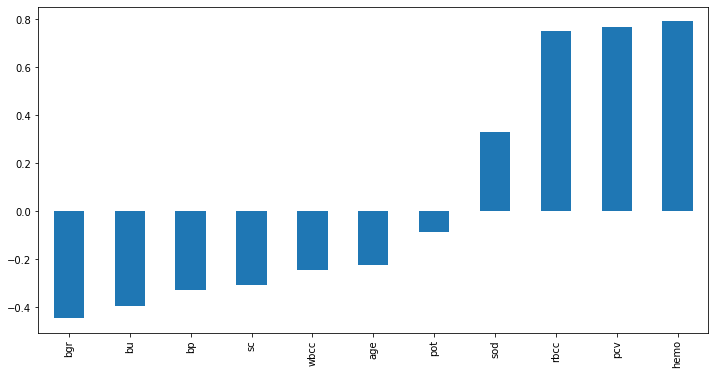

In [25]:
plt.figure(figsize = (12,6))
df_train.corr()['class'][:-1].sort_values().plot(kind = 'bar')

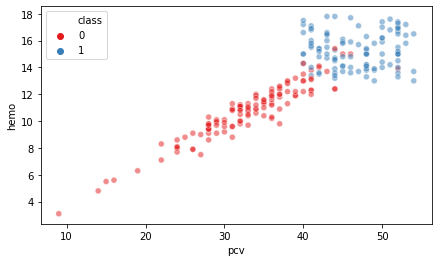

In [26]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize = (7,4))
sns.scatterplot(x = 'pcv', y = 'hemo', data=df_train, palette = 'Set1', hue = 'class', ax = axes, alpha = 0.5)

    >Hemo, pcv and rbcc are strong predictors of the target class. 
    >However, in the previous heat map, they seem highly corrolated with one another too. To avoid multicollinearity, we can probably drop two of them later on

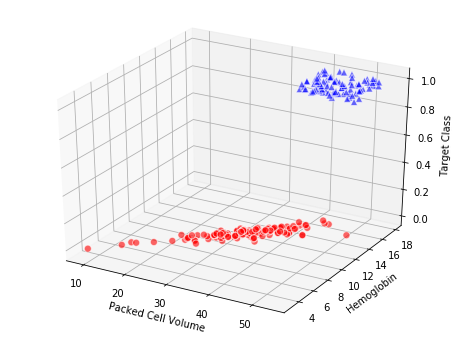

In [27]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

xs1= df_train[df_train['class'] == 0]['pcv']
xs2 = df_train[df_train['class'] == 1]['pcv']
ys1 = df_train[df_train['class'] == 0]['hemo']
ys2= df_train[df_train['class'] == 1]['hemo']
zs1 = df_train[df_train['class'] == 0]['class']
zs2 = df_train[df_train['class'] == 1]['class']
ax.scatter(xs1, ys1, zs1, s=50, alpha=0.6, edgecolors='w', c = 'r', marker = 'o')
ax.scatter(xs2, ys2, zs2, s=50, alpha=0.6, edgecolors='w', c = 'b', marker = '^')
ax.set_xlabel('Packed Cell Volume')
ax.set_ylabel('Hemoglobin')
ax.set_zlabel('Target Class')

plt.show()


    >The clusters between the two target classes can be easily observed here

In [28]:
skewness_attributes = display(df_train.select_dtypes("number").skew().sort_values(ascending=False))
print(skewness_attributes)

pot      12.483342
sc        7.019546
bu        2.784046
bgr       1.993512
bp        1.886397
wbcc      1.099511
class     0.397807
rbcc     -0.331404
hemo     -0.349931
pcv      -0.445771
age      -0.687475
sod      -7.391597
dtype: float64

None


    >'pot' attribute has a high level of skewness. Let us explore this further

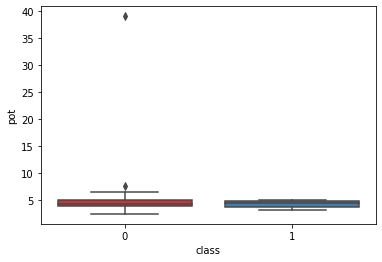

In [29]:
sns.boxplot(x = 'class', y = 'pot', data=df_train, palette = 'Set1')

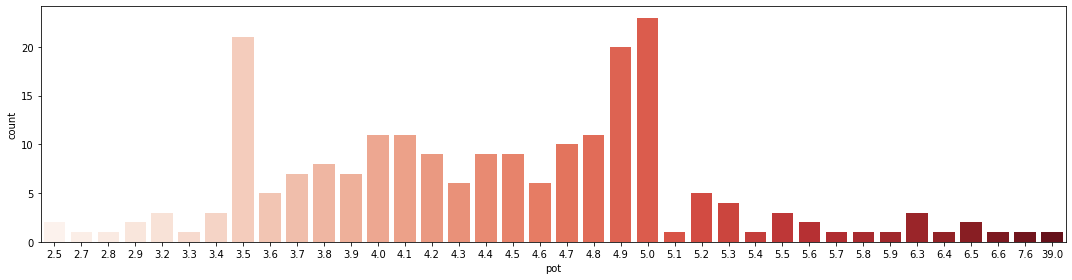

In [30]:
plt.figure(figsize = (15,4))
sns.countplot(x = 'pot', data = df_train, palette = 'Reds')
plt.tight_layout()

    >These two plots indicate the prescence of an outlier at 39.0. We will tackle this later

<H3> 3B. EXPLORATION OF NOMINAL ATTRIBUTES </H3>

    >First we will explore the ordinal attributes

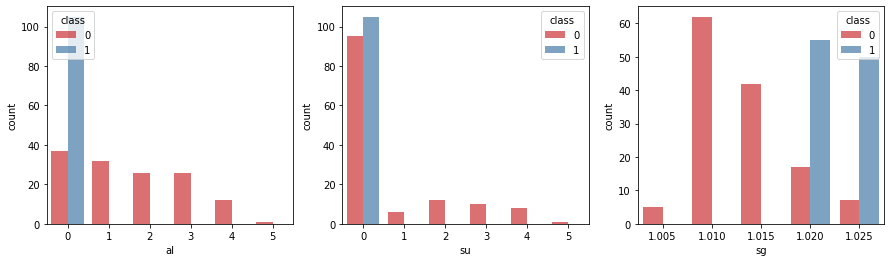

In [31]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize = (15,4))
order_al = ['0','1','2','3','4', '5']
order_sg = ['1.005','1.010','1.015','1.020','1.025']
sns.countplot(x='al', data=df_train, hue = 'class', order = order_al, ax = axes[0], palette = 'Set1', alpha = 0.7)
sns.countplot(x='su', data=df_train, hue = 'class', order = order_al, ax = axes[1], palette = 'Set1', alpha = 0.7)
sns.countplot(x='sg', data=df_train, hue = 'class', order = order_sg, ax = axes[2], palette = 'Set1', alpha = 0.7)

    >Samples without kidney diseases are limited to fewer categories

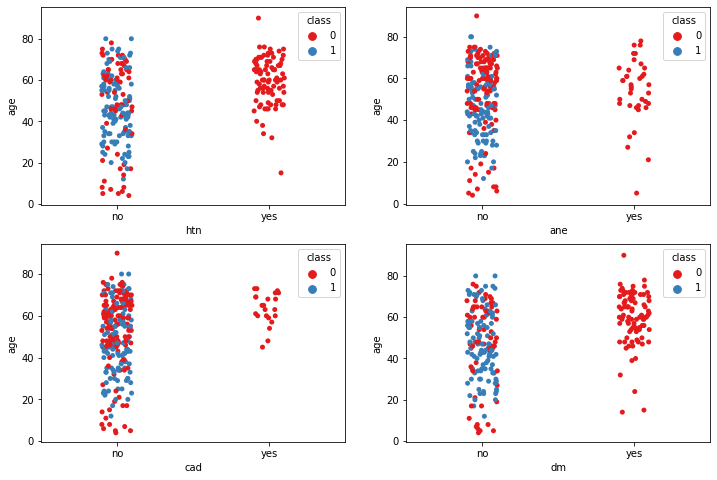

In [32]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize = (12,8))
order_nom = ['no', 'yes']
sns.stripplot(x='htn', y = 'age', data=df_train, hue = 'class',order = order_nom, palette = 'Set1', ax = axes[0][0])
sns.stripplot(x='ane', y = 'age', data=df_train, hue = 'class', order = order_nom, palette = 'Set1', ax = axes[0][1])
sns.stripplot(x='cad', y = 'age', data=df_train, hue = 'class', order = order_nom, palette = 'Set1', ax = axes[1][0])
sns.stripplot(x='dm', y = 'age', data=df_train, hue = 'class', order = order_nom, palette = 'Set1', ax = axes[1][1])

    >This graph represents corollations of chronic kidney disease with other health problems like hypertension (htn), anemia (ane), coronary artery disease (cad), and diabetes (dm)

    >Samples without kidney disease in the training data said that they don't have any of these diseases as well 

<h2>4. PREPROCESSING</h2>

<h3>4A. NOISE AND OUTLIER HANDLING</h3>

<h4>a. Pottasium </h4>

    >According to the Cleveland Clinic, normal levels of potassium in the blood are generally between 3.7 and 5.2 mEq/L for adults and 3.4-4.7 mEq/L for children. 

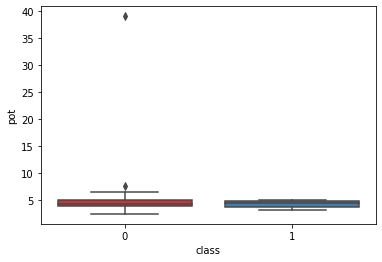

In [33]:
sns.boxplot(x = 'class', y = 'pot', data=df_train, palette = 'Set1')

In [34]:
df_train[df_train['pot'] > 30]

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,pcv,wbcc,rbcc,htn,dm,cad,appet,pe,ane,class
138,67.0,80.0,1.010,1,3,normal,abnormal,notpresent,notpresent,182.0,...,NaN,NaN,NaN,no,no,no,good,yes,no,0


In [35]:
#Noise
df_train.iloc[138,13] = df_train['pot'].median()

<h4>b. Serum Creatinine</h4>

    >Normal levels of creatinine in the blood are approximately 0.6 to 1.2 milligrams (mg) per deciliter (dL) in adult males and 0.5 to 1.1 milligrams per deciliter in adult females.

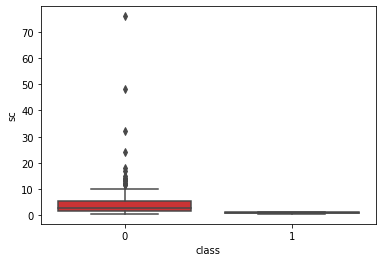

In [36]:
sns.boxplot(x = 'class', y = 'sc', data=df_train, palette = 'Set1')

In [37]:
df_train[df_train['sc'] > 15]

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,pcv,wbcc,rbcc,htn,dm,cad,appet,pe,ane,class
12,47.0,100.0,1.010,NaN,NaN,normal,NaN,notpresent,notpresent,122.0,...,33.0,10200.0,3.8,no,yes,no,good,no,no,0
102,69.0,60.0,NaN,NaN,NaN,NaN,NaN,notpresent,notpresent,171.0,...,NaN,NaN,NaN,yes,no,no,poor,no,no,0
108,68.0,70.0,1.010,0,0,NaN,normal,notpresent,notpresent,100.0,...,36.0,NaN,NaN,no,no,no,good,no,no,0
118,32.0,90.0,1.025,1,0,abnormal,abnormal,notpresent,notpresent,NaN,...,15.0,2600.0,2.8,yes,yes,no,poor,yes,yes,0
138,67.0,80.0,1.010,1,3,normal,abnormal,notpresent,notpresent,182.0,...,NaN,NaN,NaN,no,no,no,good,yes,no,0
171,60.0,90.0,NaN,NaN,NaN,NaN,NaN,notpresent,notpresent,NaN,...,32.0,6200.0,3.6,yes,yes,yes,good,no,no,0


In [38]:
#Noise
df_train.iloc[171,11] = df_train['sc'].median()
df_train.iloc[138,11] = df_train['sc'].median()
df_train.iloc[118,11] = df_train['sc'].median()
df_train.iloc[108,11] = df_train['sc'].median()
df_train.iloc[102,11] = df_train['sc'].median()
df_train.iloc[12,11] = df_train['sc'].median()

<h4>c. Sodium</h4>

    >The normal range for blood sodium levels is 135 to 145 milliequivalents per liter (mEq/L).

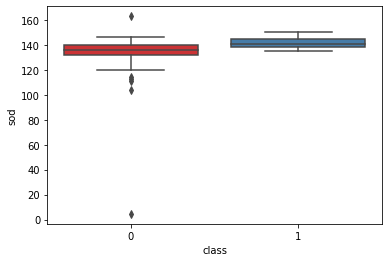

In [39]:
sns.boxplot(x = 'class', y = 'sod', data=df_train, palette = 'Set1')

In [40]:
df_train[df_train['sod'] < 10]

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,pcv,wbcc,rbcc,htn,dm,cad,appet,pe,ane,class
171,60.0,90.0,NaN,NaN,NaN,NaN,NaN,notpresent,notpresent,NaN,...,32.0,6200.0,3.6,yes,yes,yes,good,no,no,0


In [41]:
#Noise
df_train.iloc[171,12] = df_train['sod'].median()

<h4>d. Packed Cell Volume</h4>

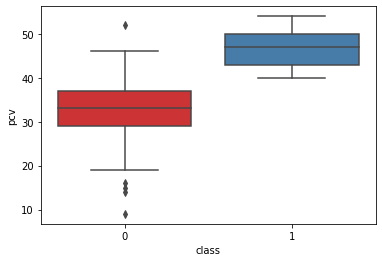

In [42]:
sns.boxplot(x = 'class', y = 'pcv', data=df_train, palette = 'Set1')

In [43]:
df_train[df_train['pcv'] < 10]

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,pcv,wbcc,rbcc,htn,dm,cad,appet,pe,ane,class
241,56.0,90.0,1.010,4,1,normal,abnormal,present,notpresent,176.0,...,9.0,5400.0,2.1,yes,yes,no,poor,yes,yes,0


In [44]:
df_train.iloc[241,15] = df_train['pcv'].median()

<h3>4B. ENCODING CATEGORICAL VARIABLES</h3>

In [45]:
categorical_columns = ['sg','al','su']

for column in categorical_columns:
    df_train[column] = pd.to_numeric(df_train[column], errors = 'ignore')

In [46]:
df_train.select_dtypes(exclude = np.number).columns

Index(['rbc', 'pc', 'pcc', 'ba', 'htn', 'dm', 'cad', 'appet', 'pe', 'ane'], dtype='object')

In [47]:
df_train['rbc'] = df_train['rbc'].map({'normal' : 0, 'abnormal' : 1})
df_train['pc'] = df_train['pc'].map({'normal' : 0, 'abnormal' : 1})
df_train['pcc'] = df_train['pcc'].map({'notpresent' : 0, 'present' : 1})
df_train['ba'] = df_train['ba'].map({'notpresent' : 0, 'present' : 1})
df_train['htn'] = df_train['htn'].map({'no' : 0, 'yes' : 1})
df_train['dm'] = df_train['dm'].map({'no' : 0, 'yes' : 1})
df_train['cad'] = df_train['cad'].map({'no' : 0, 'yes' : 1})
df_train['pe'] = df_train['pe'].map({'no' : 0, 'yes' : 1})
df_train['ane'] = df_train['ane'].map({'no' : 0, 'yes' : 1})
df_train['appet'] = df_train['appet'].map({'good' : 0, 'poor' : 1})

In [48]:
numeric_columns = ['age','bp', 'bgr','bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wbcc', 'rbcc']

for column in numeric_columns:
    df_test[column] = pd.to_numeric(df_test[column], errors = 'ignore')


categorical_columns = ['sg','al','su']

for column in categorical_columns:
    df_test[column] = pd.to_numeric(df_test[column], errors = 'ignore')

In [49]:
df_test['rbc'] = df_test['rbc'].map({'normal' : 0, 'abnormal' : 1})
df_test['pc'] = df_test['pc'].map({'normal' : 0, 'abnormal' : 1})
df_test['pcc'] = df_test['pcc'].map({'notpresent' : 0, 'present' : 1})
df_test['ba'] = df_test['ba'].map({'notpresent' : 0, 'present' : 1})
df_test['htn'] = df_test['htn'].map({'no' : 0, 'yes' : 1})
df_test['dm'] = df_test['dm'].map({'no' : 0, 'yes' : 1})
df_test['cad'] = df_test['cad'].map({'no' : 0, 'yes' : 1})
df_test['pe'] = df_test['pe'].map({'no' : 0, 'yes' : 1})
df_test['ane'] = df_test['ane'].map({'no' : 0, 'yes' : 1})
df_test['appet'] = df_test['appet'].map({'good' : 0, 'poor' : 1})
df_test['class'] = df_test['class'].map({'ckd' : 0, 'notckd' : 1})

<h3>4C. SCALING AND IMPUTATION OF MISSING DATA</h3>

    >Tried out Two Methods:
    >KNN Imputation 
    >Mean/Median/Mode Imputation

    >KNN takes feature correlations into account however it led to problems with categorical variables as it relies on distance and mean-based calculations.
    >Therefore, Mean + Median Imputation was used

In [50]:
X_train = df_train.drop('class', axis = 1)
y_train = df_train['class']

X_test = df_test.drop('class', axis = 1)
y_test = df_test['class']


In [51]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [52]:
X_train = pd.DataFrame(X_train, columns = df_train.columns[0:24])
X_test = pd.DataFrame(X_test, columns = df_test.columns[0:24])

mean_cols = ['age','bp','bgr','bu','sc','sod','pot','hemo','pcv','wbcc','rbcc']

for col in mean_cols:
    mean = X_train[col].mean()
    X_train[col] = X_train[col].fillna(mean)
    X_test[col] = X_test[col].fillna(mean)
    
mode_cols = ['sg', 'al', 'su', 'rbc', 'pc', 'pcc', 'ba', 'htn', 'dm', 'cad', 'appet', 'pe', 'ane']

for col in mode_cols:
    mode = X_train[col].mode()
    X_train[col]=X_train[col].fillna(value = mode[0])
    X_test[col]=X_test[col].fillna(value = mode[0])

<h3>4D. FEATURE SELECTION</h3>

    >Feature Selection is the process of selecting features which contribute most to the prediction variable

In [53]:
X_train = pd.DataFrame(X_train, columns = df_train.columns[0:24])
X_test = pd.DataFrame(X_test, columns = df_test.columns[0:24])

In [54]:
#Unscaled Copy needed in physician step in clustering 

X_train_copy = pd.DataFrame(scaler.inverse_transform(X_train), columns = X_train.columns)
X_test_copy = pd.DataFrame(scaler.inverse_transform(X_test), columns = X_test.columns)

In [55]:
X_train_copy = X_train_copy.round(3)
X_test_copy = X_test_copy.round(3)

In [56]:
#Drop features whose correlation with one another is more than 0.8 because they provide duplicate information
#hemo and pcv correlation - 0.87
#hemo and rbcc correlation - 0.81
X_train = X_train.drop(['pcv','rbcc'], axis = 1)
X_test = X_test.drop(['pcv','rbcc'], axis = 1)

<h4>1. Recursive Feature Elimination (Wrapper Method)</h4>

    >Works by removing attributes recursively and building a model from the features that remain.

In [57]:
model = RandomForestClassifier()
#SVM also selects same features
rfe = RFE(model,8)
X_train_rfe = rfe.fit_transform(X_train, y_train)

model.fit(X_train_rfe, y_train)
score = model.score(X_train_rfe,y_train)
print('score', score)
temp = pd.Series(rfe.support_, index = X_train.columns)
selected_features_rfe = temp[temp == True].index

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass n_features_to_select=8 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


score 1.0


In [58]:
selected_features_rfe

Index(['sg', 'al', 'bgr', 'bu', 'sc', 'hemo', 'htn', 'dm'], dtype='object')

<h4>2. Lasso Regularization (Embedded Method)</h4>

    >At each iteration, the features which contribute the most are selected
    >Regularization methods are the most commonly used embedded methods which penalize a feature given a 
    coefficient threshold


In [59]:
reg = LassoCV()
reg.fit(X_train, y_train)
print("Best alpha using built-in LassoCV: %f" % reg.alpha_)
print("Best score using built-in LassoCV: %f" %reg.score(X_train,y_train))
selected_features_lasso = pd.Series(reg.coef_, index = X_train.columns)

Best alpha using built-in LassoCV: 0.005265
Best score using built-in LassoCV: 0.731181


In [60]:
print("Lasso picked " + str(sum(selected_features_lasso != 0)) + " variables and eliminated the other " +  str(sum(selected_features_lasso == 0)) + " variables")

Lasso picked 6 variables and eliminated the other 16 variables


Text(0.5, 1.0, 'Feature importance using Lasso Model')

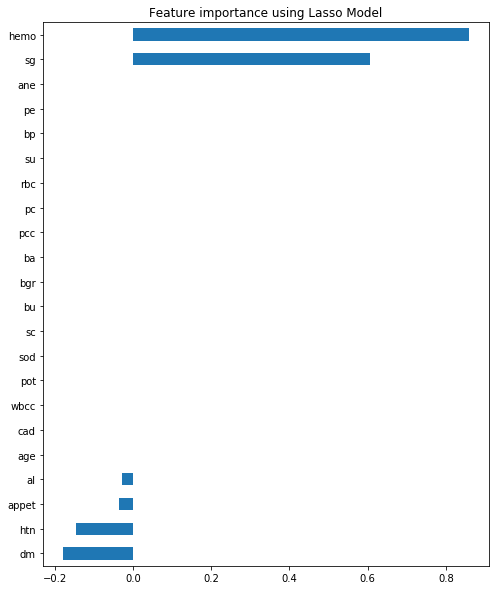

In [61]:
selected_features_lasso = selected_features_lasso.sort_values()
plt.rcParams['figure.figsize'] = (8.0, 10.0)
selected_features_lasso.plot(kind = "barh")
plt.title("Feature importance using Lasso Model")

<h4>3. Pearson's Corrolation (Filter Based Method)</h4>

In [62]:
pearsons_df_x = pd.DataFrame(X_train, columns = X_train.columns)
pearsons_df_y = pd.DataFrame(y_train)
pearsons_df = pd.concat([pearsons_df_x, pearsons_df_y], axis = 1)

In [63]:
pearsons_df = pearsons_df.corr()['class'][0:24].abs().sort_values(ascending = False)[1:9]

In [64]:
pearsons_df

hemo    0.752760
sg      0.680590
dm      0.598928
htn     0.594004
al      0.529970
sc      0.453753
bgr     0.424698
sod     0.409018
Name: class, dtype: float64

    >According to these three feature selection methods, the top 8 attributes for classification are : 
    ['hemo', 'sg', 'al', 'bgr', 'htn', 'dm', 'appet', 'sc']
    >age will be kept in the dataframe for clustering as age is important indicator of ckd stage

In [65]:
to_keep_cols = ['hemo', 'sg', 'al', 'bgr', 'htn', 'dm', 'appet','sc', 'age']

X_tr_cluster= X_train.copy()

for col in X_train.columns:
    if col not in to_keep_cols:
        X_train = X_train.drop(col, axis = 1)
        X_test = X_test.drop(col, axis = 1)

        
X_tr_cluster= X_train.copy()
X_train = X_train.drop('age', axis = 1)
X_te_cluster = X_test.copy()
X_test = X_test.drop('age', axis = 1)

<h2>5. MACHINE LEARNING MODELS:</h2>

<h3>5A. DECISION TREE:</h3>

    >With original parameters:

In [66]:
dt = DecisionTreeClassifier(random_state = 1)
dt.fit(X_train, y_train)
dt_pred = dt.predict(X_test)
print(confusion_matrix(y_test, dt_pred))
print(classification_report(y_test, dt_pred))


[[88  2]
 [ 2 40]]
              precision    recall  f1-score   support

           0       0.98      0.98      0.98        90
           1       0.95      0.95      0.95        42

    accuracy                           0.97       132
   macro avg       0.97      0.97      0.97       132
weighted avg       0.97      0.97      0.97       132



In [67]:
#plt.figure(figsize = (10,8))
#tree.plot_tree(dt, feature_names = X_train.columns, class_names = ['ckd', 'notckd'], filled = True, rounded = True)

    >With hyperparameter tuning: (5-fold cross validated)
    
    min_samples_split: The minimum number of samples a node must contain in order to consider splitting.
    min_samples_leaf: The minimum number of samples needed to be considered a leaf node. 
    max_depth: This determines the maximum depth of the tree.

In [68]:
# parameters={'min_samples_split' : range(2,20,1),'max_depth': range(1,20,1), 'criterion' : ['gini', 'entropy'], 'min_samples_leaf' : [2,8,1], 'random_state' : [1]}
# grid=GridSearchCV(dt,parameters, verbose = 3, cv = 5)
# grid.fit(X_train,y_train)
# print(grid.best_estimator_)
# print(grid.best_params_)
# y_pred = grid.predict(X_test)
# print(confusion_matrix(y_test, y_pred))
# print(classification_report(y_test, y_pred)) 

    >Hyperparameter tuning did not change really the performance of the model

              precision    recall  f1-score   support

           0       0.98      0.98      0.98        90
           1       0.95      0.95      0.95        42

    accuracy                           0.97       132
   macro avg       0.97      0.97      0.97       132
weighted avg       0.97      0.97      0.97       132



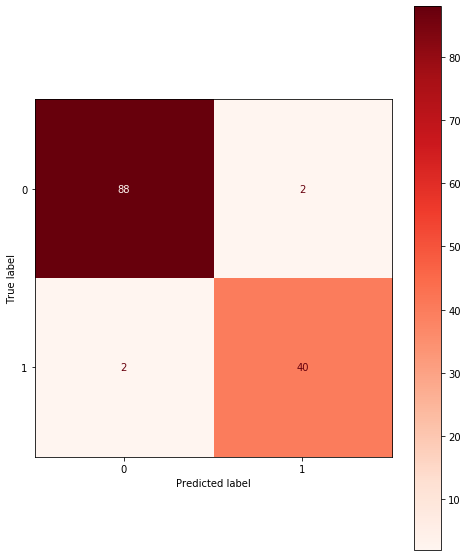

In [69]:
dt = DecisionTreeClassifier(criterion = 'gini', max_depth = 4, min_samples_leaf = 1, min_samples_split = 2,random_state = 1)
dt.fit(X_train, y_train)
dt_pred = dt.predict(X_test)
#sns.set(font_scale=3.0)
disp = plot_confusion_matrix(dt, X_test, y_test,cmap= plt.cm.Reds)
print(classification_report(y_test, dt_pred))


[Text(223.2, 391.392, 'hemo <= 0.69\ngini = 0.481\nsamples = 268\nvalue = [160, 108]\nclass = ckd'), Text(133.92000000000002, 304.416, 'sc <= 0.045\ngini = 0.096\nsamples = 158\nvalue = [150, 8]\nclass = ckd'), Text(89.28, 217.44, 'hemo <= 0.641\ngini = 0.417\nsamples = 27\nvalue = [19, 8]\nclass = ckd'), Text(44.64, 130.464, 'gini = 0.0\nsamples = 15\nvalue = [15, 0]\nclass = ckd'), Text(133.92000000000002, 130.464, 'sg <= 0.625\ngini = 0.444\nsamples = 12\nvalue = [4, 8]\nclass = notckd'), Text(89.28, 43.488, 'gini = 0.0\nsamples = 4\nvalue = [4, 0]\nclass = ckd'), Text(178.56, 43.488, 'gini = 0.0\nsamples = 8\nvalue = [0, 8]\nclass = notckd'), Text(178.56, 217.44, 'gini = 0.0\nsamples = 131\nvalue = [131, 0]\nclass = ckd'), Text(312.48, 304.416, 'sg <= 0.625\ngini = 0.165\nsamples = 110\nvalue = [10, 100]\nclass = notckd'), Text(267.84000000000003, 217.44, 'gini = 0.0\nsamples = 8\nvalue = [8, 0]\nclass = ckd'), Text(357.12, 217.44, 'htn <= 0.5\ngini = 0.038\nsamples = 102\nvalue = 

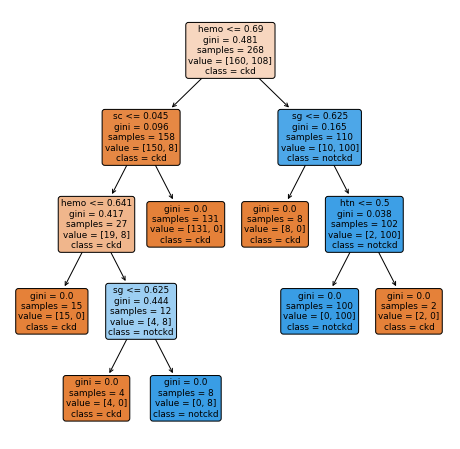

In [70]:
plt.figure(figsize = (8,8))
print(tree.plot_tree(dt, feature_names = X_train.columns, class_names = ['ckd', 'notckd'], filled = True, rounded = True))

In [72]:
print('Decision Tree AUC:', roc_auc_score(y_test, dt_pred))
roc_scores = []
roc_scores.append(roc_auc_score(y_test, dt_pred))

Decision Tree AUC: 0.965079365079365


In [73]:
wrong_predictions = pd.DataFrame(dt_pred, columns = ['is_same']).apply(lambda x : x == y_test)   
dt_pred = pd.Series(dt_pred)
wrong_pedictions = pd.concat([wrong_predictions, dt_pred, y_test], axis = 1)

In [74]:
wrong_predictions[wrong_predictions['is_same'] == False] 

,is_same
79,False
89,False
90,False
122,False


<h3>5B. RANDOM FOREST:</h3>

In [75]:
rfc = RandomForestClassifier(random_state = 1)
rfc.fit(X_train, y_train)
rfc_pred = rfc.predict(X_test)
print('Random Forest')
print(confusion_matrix(y_test, rfc_pred))
print(classification_report(y_test, rfc_pred))

Random Forest
[[89  1]
 [ 0 42]]
              precision    recall  f1-score   support

           0       1.00      0.99      0.99        90
           1       0.98      1.00      0.99        42

    accuracy                           0.99       132
   macro avg       0.99      0.99      0.99       132
weighted avg       0.99      0.99      0.99       132



    >With hyperparameter tuning: (5-fold cross validated)
     
     n_estimators: number of trees in the foreset

In [215]:
# parameters={'n_estimators' : range(20,200, 10), 'max_features' : range(2,8,1), 'max_samples' : [0.5], 'random_state' : [1]}
# grid=GridSearchCV(rfc,parameters, verbose = 3, cv = 5)
# grid.fit(X_train,y_train) 
# print(grid.best_estimator_)
# print(grid.best_params_)
# y_pred = grid.predict(X_test)
# print(confusion_matrix(y_test, y_pred))
# print(classification_report(y_test, y_pred)) 


    >Hyperparameter tuning did not change the performance for Random Forest, however we did simplify the trees in the forest

Random Forest
              precision    recall  f1-score   support

           0       1.00      0.99      0.99        90
           1       0.98      1.00      0.99        42

    accuracy                           0.99       132
   macro avg       0.99      0.99      0.99       132
weighted avg       0.99      0.99      0.99       132



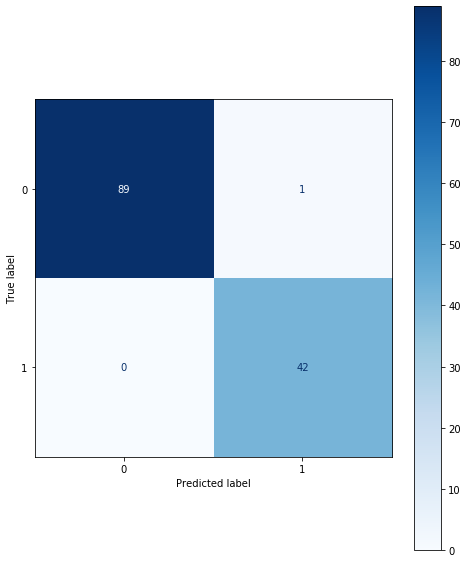

In [77]:
rfc = RandomForestClassifier(n_estimators= 100, max_features = 2, max_samples = 0.5, random_state = 1)
rfc.fit(X_train, y_train)
rfc_pred = rfc.predict(X_test)
print('Random Forest')
disp = plot_confusion_matrix(rfc, X_test, y_test,cmap= plt.cm.Blues)
#sns.set(font_scale=3.0)
print(classification_report(y_test, rfc_pred))

In [78]:
wrong_predictions = pd.DataFrame(rfc_pred, columns = ['is_same']).apply(lambda x : x == y_test)   
rfc_pred = pd.Series(rfc_pred)
wrong_pedictions = pd.concat([wrong_predictions, rfc_pred, y_test], axis = 1)

In [79]:
wrong_predictions[wrong_predictions['is_same'] == False] 

,is_same
79,False


In [80]:
print('Random Forest AUC:', roc_auc_score(y_test, rfc_pred))
roc_scores.append(roc_auc_score(y_test, rfc_pred))

Random Forest AUC: 0.9944444444444445


<h3>5C. SUPPORT VECTOR MACHINE</h3>

In [81]:
svc = SVC()
svc.fit(X_train, y_train)
svm_pred = svc.predict(X_test)
print(confusion_matrix(y_test, svm_pred))
print(classification_report(y_test, svm_pred))

[[87  3]
 [ 0 42]]
              precision    recall  f1-score   support

           0       1.00      0.97      0.98        90
           1       0.93      1.00      0.97        42

    accuracy                           0.98       132
   macro avg       0.97      0.98      0.97       132
weighted avg       0.98      0.98      0.98       132



    >With hyperparameter tuning: (5-fold cross validated)
    
    C: C controls the trade off between smooth decision boundary and classifying the training points correctly
    gamma: The higher the gamma value it tries to exactly fit the training data set
    kernel: kernel parameter selects the type of hyperplane used to separate the data

In [82]:
# params_grid = {'C':[0.1,1,10,100,1000], 'gamma' : [1,0.1,0.01, 0.001, 0.0001], 'kernel' : ['linear', 'rbf','poly']}
# grid = GridSearchCV(svc, params_grid, verbose = 3, cv = 5)
# grid.fit(X_train, y_train)
# print(grid.best_estimator_)
# print(grid.best_params_)
# grid_predictions = grid.predict(X_test)
# print(confusion_matrix(y_test, grid_predictions))
# print(classification_report(y_test, grid_predictions))

    >Hyperparameter tuning improved accuracy from 97% to 99%. This is because kernel = 'rbf' is the best kernel for this dataset. 

In [83]:
svc = SVC(C=100, gamma=1, kernel='rbf')
svc.fit(X_train, y_train)
svm_pred = svc.predict(X_test)

              precision    recall  f1-score   support

           0       1.00      0.98      0.99        90
           1       0.95      1.00      0.98        42

    accuracy                           0.98       132
   macro avg       0.98      0.99      0.98       132
weighted avg       0.99      0.98      0.98       132



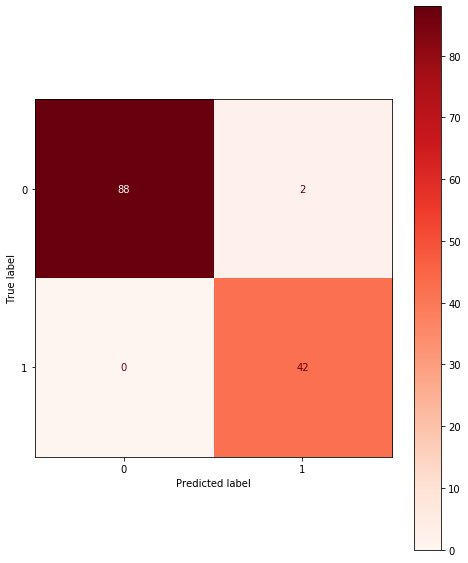

In [84]:
#sns.set(font_scale=3.0)
disp = plot_confusion_matrix(svc, X_test, y_test,cmap= plt.cm.Reds)
print(classification_report(y_test, svm_pred))

In [85]:
wrong_predictions = pd.DataFrame(svm_pred, columns = ['is_same']).apply(lambda x : x == y_test)   

In [86]:
wrong_predictions[wrong_predictions['is_same'] == False] 

,is_same
68,False
104,False


In [87]:
print('SVM AUC:', roc_auc_score(y_test, svm_pred))
roc_scores.append(roc_auc_score(y_test, svm_pred))

SVM AUC: 0.9888888888888888


<h3>5D. NEURAL NETWORKS</h3>

In [88]:
tf.keras.backend.set_floatx('float64')

In [89]:
model = Sequential()

model.add(Dense(units = 8, activation = 'relu'))
model.add(Dense(units = 4, activation = 'relu'))
model.add(Dense(units = 1, activation = 'sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam')

    >units = nodes
    >activation = introduces nonlinear real-world properties to artificial neural networks -- otherwise it will 
    just be a linear regression model
    >optimizer = change the attributes of neural network such as weights and learning rate in order to reduce the losses

In [90]:
model.fit(x=X_train, 
          y=y_train, 
          epochs=1000,
          validation_data=(X_test, y_test), verbose=0)

In [91]:
model_loss = pd.DataFrame(model.history.history)

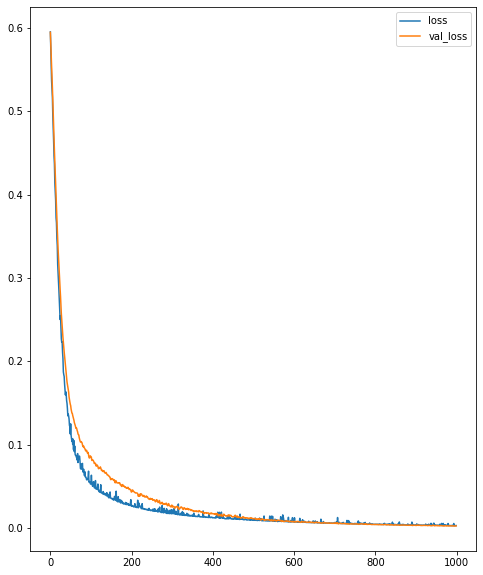

In [92]:
model_loss.plot()

<h5>Early Stopping:</h5>

    > Patience = the number of epochs to wait before early stop if no progress on the validation set.

In [94]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=10)

In [96]:
model = Sequential()

model.add(Dense(units = 8, activation = 'relu'))
model.add(Dense(units = 4, activation = 'relu'))
model.add(Dense(units = 1, activation = 'sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam')

In [97]:
model.fit(x=X_train, 
          y=y_train, 
          epochs=1000,
          validation_data=(X_test, y_test), verbose=0,
          callbacks=[early_stop]
          )

In [98]:
model_loss = pd.DataFrame(model.history.history)

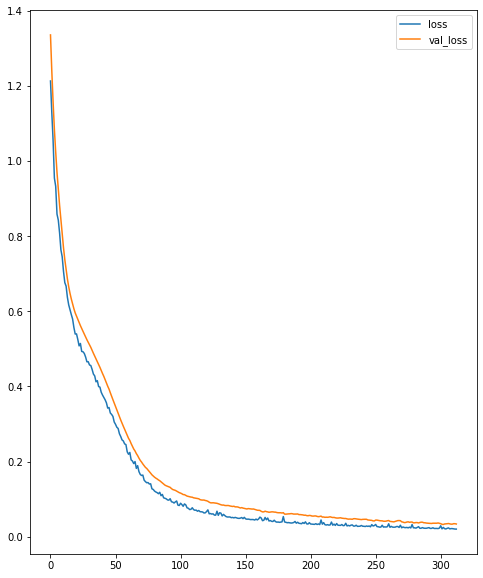

In [99]:
model_loss.plot()

<h5> Dropout </h5>

    >Randomly sets the outgoing edges of neurons to 0 at each update of the training phase

    >Training set: For each hidden layer, for each training sample, for each iteration, ignore (zero out) a random fraction, p, of nodes (and corresponding activations)

    >Testing set: Use all activations, but reduce them by a factor p (to account for the missing activations during training)


    >The model with the best weights were saved and restored~

In [100]:
model = Sequential()

model.add(Dense(units = 8, activation = 'relu'))
model.add(Dropout(0.3))

model.add(Dense(units = 4, activation = 'relu'))
model.add(Dropout(0.3))

model.add(Dense(units = 1, activation = 'sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics = 'accuracy')

model.load_weights('./checkpoints/my_checkpoint')

In [101]:
model.fit(x=X_train, 
          y=y_train, 
          epochs=1000,
          validation_data=(X_test, y_test), verbose=0,
          callbacks=[early_stop]
          )

#model.save_weights('./checkpoints/my_checkpoint')

In [104]:
nn_pred = model.predict_classes(X_test)

In [105]:
print(confusion_matrix(y_test,nn_pred))
print(classification_report(y_test,nn_pred))

[[89  1]
 [ 0 42]]
              precision    recall  f1-score   support

           0       1.00      0.99      0.99        90
           1       0.98      1.00      0.99        42

    accuracy                           0.99       132
   macro avg       0.99      0.99      0.99       132
weighted avg       0.99      0.99      0.99       132



In [106]:
wrong_predictions = pd.DataFrame(nn_pred, columns = ['is_same']).apply(lambda x : x == y_test)  

In [107]:
wrong_predictions[wrong_predictions['is_same'] == False] 

,is_same
104,False


In [108]:
print('Neural Networks AUC:', roc_auc_score(y_test, nn_pred))
roc_scores.append(roc_auc_score(y_test, nn_pred))

Neural Networks AUC: 0.9944444444444445


<h3> 5E. HYBRID MODEL </h3>

    >Utilize Stacking 
    
    >Stacking requires k-fold cross training while Blending requires train-test-split(2-fold)

Special thank you to this notebook: https://www.kaggle.com/arthurtok/introduction-to-ensembling-stacking-in-python

In [109]:
n_train = df_train.shape[0]
n_test = df_test.shape[0]
n_splits = 5
seed = 0
kfold = KFold(n_splits= n_splits, random_state= seed, shuffle = True)

In [110]:
def get_out_of_folds(clf, x_train, y_train, x_test):
    '''
        Creates predictions of base classifiers that are later used as input for training to meta classifier
    '''
    oof_train = np.zeros((n_train,))
    oof_test = np.zeros((n_test,))
    oof_test_skf = np.empty((n_splits, n_test))

    for i, (train_index, test_index) in enumerate(kfold.split(X_train)):
        x_tr = X_train.iloc[train_index]
        y_tr = y_train.iloc[train_index]
        x_te = X_train.iloc[test_index]
        #print(i, train_index, test_index)
        clf.fit(x_tr, y_tr)#fit using 4 folds(224 records) + based on 10 features in X_train

        oof_train[test_index] = clf.predict_proba(x_te)[:,1]#predict 5th fold based on the 10 features 
        oof_test_skf[i, :] = clf.predict_proba(x_test)[:,1]#predict X_test 5 times (kfold = 5) and take mean (also 10 features)

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)
    #oof_train has predictions for all 280 records in X_train and oof_test has predictions for 120 records in X_test

In [111]:
#Create Base Models
#Seed to ensure that output doesn't vary from run to run

rf = RandomForestClassifier(random_state = seed)
svm = SVC(probability = True, random_state = seed,C=100, gamma=1, kernel='rbf')
nb = GaussianNB()

In [112]:
rf_oof_train, rf_oof_test = get_out_of_folds(rf, X_train, y_train, X_test)
svm_oof_train, svm_oof_test = get_out_of_folds(svm, X_train, y_train, X_test)
nb_oof_train, nb_oof_test = get_out_of_folds(nb, X_train, y_train, X_test)

In [113]:
base_predictions_train = pd.DataFrame( {
                                        'RandomForest': rf_oof_train.ravel(),
                                        'SVC': svm_oof_train.ravel(),
                                        'NB': nb_oof_train.ravel(),
                                     })
base_predictions_train.head()

,RandomForest,SVC,NB
0,1.00,1.000000,1.0
1,0.04,0.000942,0.0
2,1.00,1.000000,1.0
3,0.99,0.975335,1.0
4,0.02,0.003314,0.0


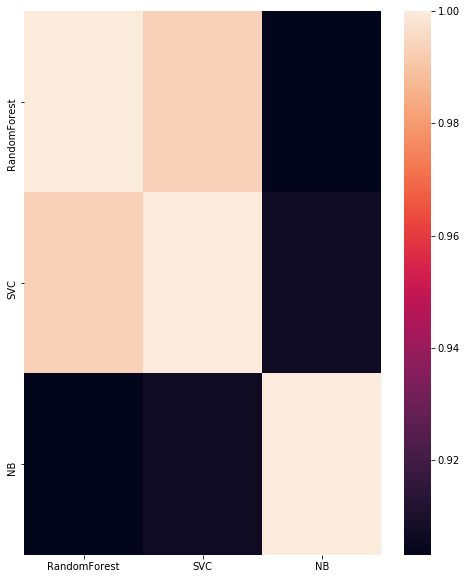

In [114]:
sns.heatmap(base_predictions_train.corr())

    >It is better to have high performing but uncorrelated models in a hybrid model. Highly correlated models give no new useful information since they just pass and fail in the diagnosis of the same records~
    
     >Random Forest and SVC were also chosen in that manner. First, the samples that they misdiagnosed were 
     analyzed. After discovering that they misdiagnozed different samples and the misdiagnoses of one model was
     correctly diagnosed in another model, they were chosen as the base models 

In [116]:
hybrid_train = np.concatenate((rf_oof_train, svm_oof_train), axis=1)
hybrid_test = np.concatenate(( rf_oof_test, svm_oof_test), axis=1)

In [117]:
nb = GaussianNB().fit(hybrid_train, y_train)
hybrid_pred = nb.predict(hybrid_test)

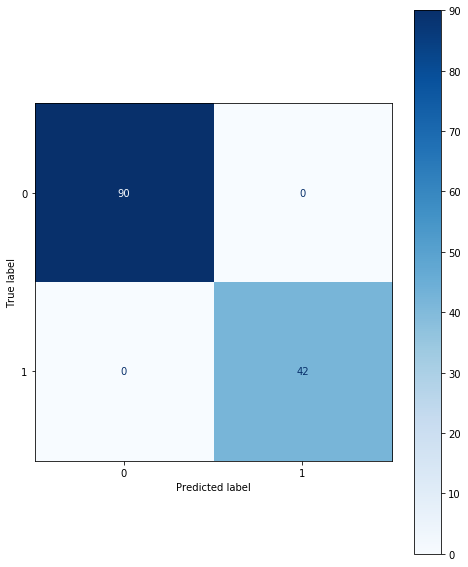

In [118]:
disp = plot_confusion_matrix(nb, hybrid_test, y_test,cmap= plt.cm.Blues)

In [119]:
print(classification_report(hybrid_pred.round(), y_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        90
           1       1.00      1.00      1.00        42

    accuracy                           1.00       132
   macro avg       1.00      1.00      1.00       132
weighted avg       1.00      1.00      1.00       132



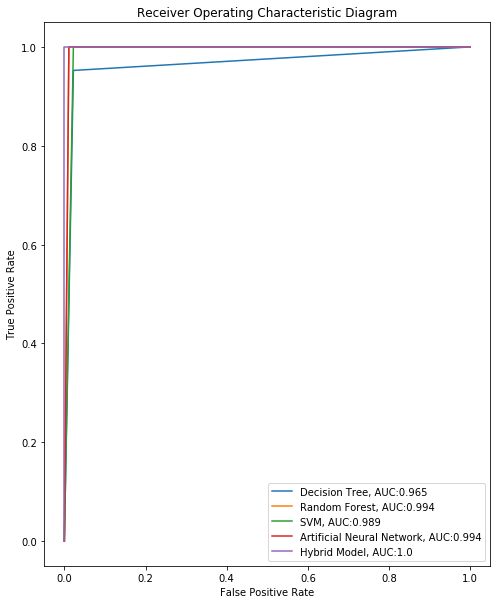

In [120]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, dt_pred)
plt.plot(fpr,tpr, label = 'Decision Tree, AUC:' + str(round(roc_auc_score(y_test, dt_pred),3)))
fpr, tpr, thresholds = roc_curve(y_test, rfc_pred)
plt.plot(fpr,tpr, label = 'Random Forest, AUC:' + str(round(roc_auc_score(y_test, rfc_pred),3)))
fpr, tpr, thresholds = roc_curve(y_test, svm_pred)
plt.plot(fpr,tpr,  label = 'SVM, AUC:' +  str(round(roc_auc_score(y_test, svm_pred),3)))
fpr, tpr, thresholds = roc_curve(y_test, nn_pred)
plt.plot(fpr,tpr,  label = 'Artificial Neural Network, AUC:' + str(round(roc_auc_score(y_test, nn_pred),3)))
fpr, tpr, thresholds = roc_curve(y_test, hybrid_pred)
plt.plot(fpr,tpr,  label = 'Hybrid Model, AUC:' + str(round(roc_auc_score(y_test, hybrid_pred),3)))

# Print ROC curve
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Diagram')
plt.legend(loc="lower right")
plt.legend(loc="lower right")
plt.show() 

<h2> 5F. CLUSTERING </h2>

<h3>1. K-Means Clustering</h3>


In [129]:
whole_df = pd.concat([X_tr_cluster, X_te_cluster]).reset_index(drop = True)

In [130]:
pca = PCA(n_components=2)
pca.fit(whole_df)
pca_res = pca.transform(whole_df)

In [131]:
pca_df = pd.DataFrame(pca_res)

In [132]:
predictions_train = pd.Series(y_train)
predictions_test = pd.Series(y_test)

predictions = pd.concat([predictions_train, predictions_test]).reset_index(drop = True)
predictions.columns = 'class'

In [133]:
cluster_df = pd.concat([pca_df, predictions], axis = 1)
cluster_df = cluster_df[cluster_df['class'] == 0]
cluster_df = cluster_df.drop('class', axis = 1)
cluster_df = cluster_df.reset_index(drop = True)

In [134]:
print(cluster_df.head())

          0         1
0  0.291701 -0.180369
1  0.128367 -0.238661
2  0.158626 -0.209861
3  0.709079 -0.590220
4  0.128570 -0.218125


In [135]:
kmeans = KMeans(n_clusters = 6) 
y_kmeans = kmeans.fit_predict(cluster_df)

Text(0, 0.5, 'Second Principal Component')

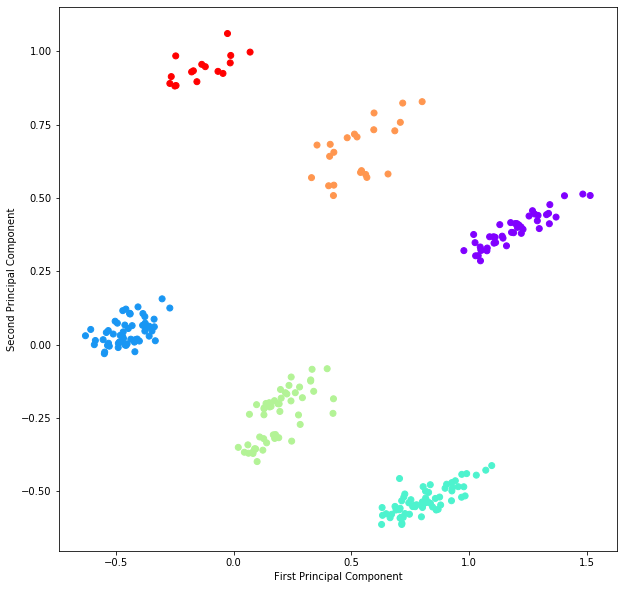

In [136]:
plt.figure(figsize = (10,10))
plt.scatter(cluster_df.iloc[:,0], cluster_df.iloc[:,1], c = kmeans.labels_, cmap = 'rainbow')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')

<h3> 2. Hierarchical Clustering </h3>

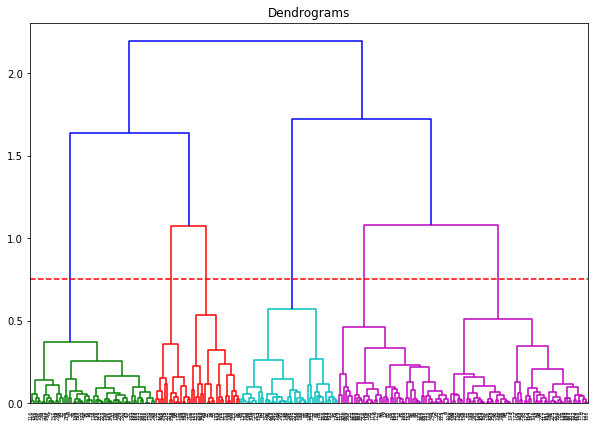

In [137]:
import scipy.cluster.hierarchy as shc
plt.figure(figsize=(10, 7))  
plt.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(cluster_df, method='complete'))
plt.axhline(y=0.75, color='r', linestyle='--')

In [138]:
from sklearn.cluster import AgglomerativeClustering
cluster = AgglomerativeClustering(n_clusters= 6, affinity='euclidean', linkage='complete')  
cluster.fit_predict(cluster_df)

array([4, 4, 4, 1, 4, 1, 4, 3, 1, 3, 2, 0, 4, 1, 4, 4, 0, 3, 3, 3, 4, 2,
       1, 3, 3, 4, 3, 2, 1, 2, 4, 3, 3, 0, 0, 2, 3, 3, 3, 5, 3, 1, 1, 1,
       0, 3, 1, 1, 1, 3, 0, 0, 2, 3, 1, 4, 4, 3, 0, 1, 0, 1, 2, 0, 0, 4,
       3, 1, 0, 1, 3, 4, 2, 5, 2, 3, 4, 3, 0, 3, 0, 2, 5, 0, 5, 0, 0, 4,
       5, 4, 0, 1, 2, 4, 1, 4, 4, 3, 5, 1, 4, 3, 4, 1, 1, 2, 1, 1, 2, 1,
       0, 2, 4, 2, 1, 1, 3, 1, 4, 4, 3, 3, 1, 1, 0, 4, 1, 1, 3, 3, 1, 1,
       2, 4, 0, 2, 1, 3, 3, 1, 1, 4, 0, 0, 0, 1, 1, 1, 0, 1, 3, 3, 3, 2,
       4, 4, 3, 0, 3, 0, 4, 3, 0, 1, 4, 5, 0, 4, 1, 2, 4, 5, 5, 4, 0, 4,
       1, 1, 3, 3, 1, 1, 0, 0, 5, 3, 1, 4, 0, 5, 1, 1, 1, 1, 3, 4, 0, 3,
       0, 3, 4, 5, 3, 1, 3, 1, 1, 4, 5, 0, 4, 5, 2, 3, 0, 4, 4, 1, 4, 3,
       3, 1, 4, 3, 1, 4, 4, 0, 3, 0, 1, 3, 1, 3, 4, 0, 2, 4, 5, 2, 0, 0,
       3, 1, 3, 5, 0, 3, 1, 0])

In [144]:
cluster_df.head()

,0,1
0,0.291701,-0.180369
1,0.128367,-0.238661
2,0.158626,-0.209861
3,0.709079,-0.590220
4,0.128570,-0.218125


Text(0, 0.5, 'Second Principal Component')

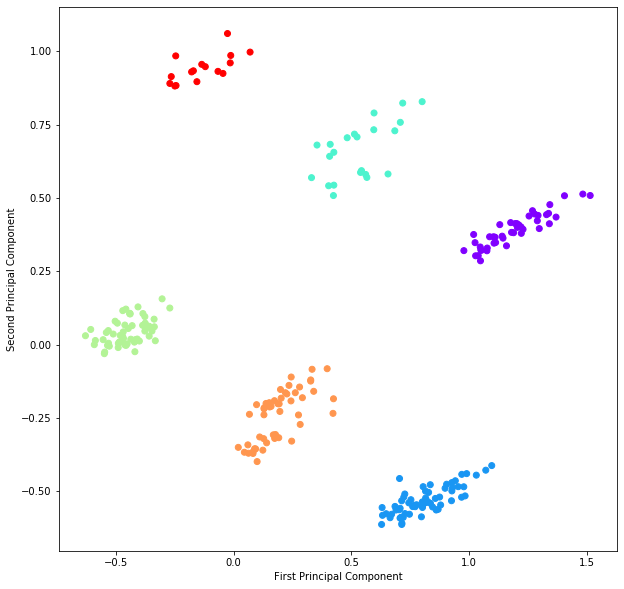

In [145]:
plt.figure(figsize = (10,10))
plt.scatter(cluster_df.iloc[:,0], cluster_df.iloc[:,1], c = cluster.labels_, cmap = 'rainbow')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')

<h2> 5G. SELF ORGANIZING MAP </h2>

In [146]:
from sompy.sompy import SOMFactory

sm = SOMFactory().build(cluster_df.to_numpy(), initialization='pca', component_names= ['Self Organizing Map','Self Organizing Map'], lattice = 'hexa', mapsize = [50,50])
sm.train(n_job=1, verbose=False, train_rough_len=10, train_finetune_len=10)

In [147]:
topographic_error = sm.calculate_topographic_error()
quantization_error = sm.calculate_quantization_error()
print ("Topographic error = %s; Quantization error = %s" % (topographic_error, quantization_error))

Topographic error = 0.412; Quantization error = 0.0068150548514754805


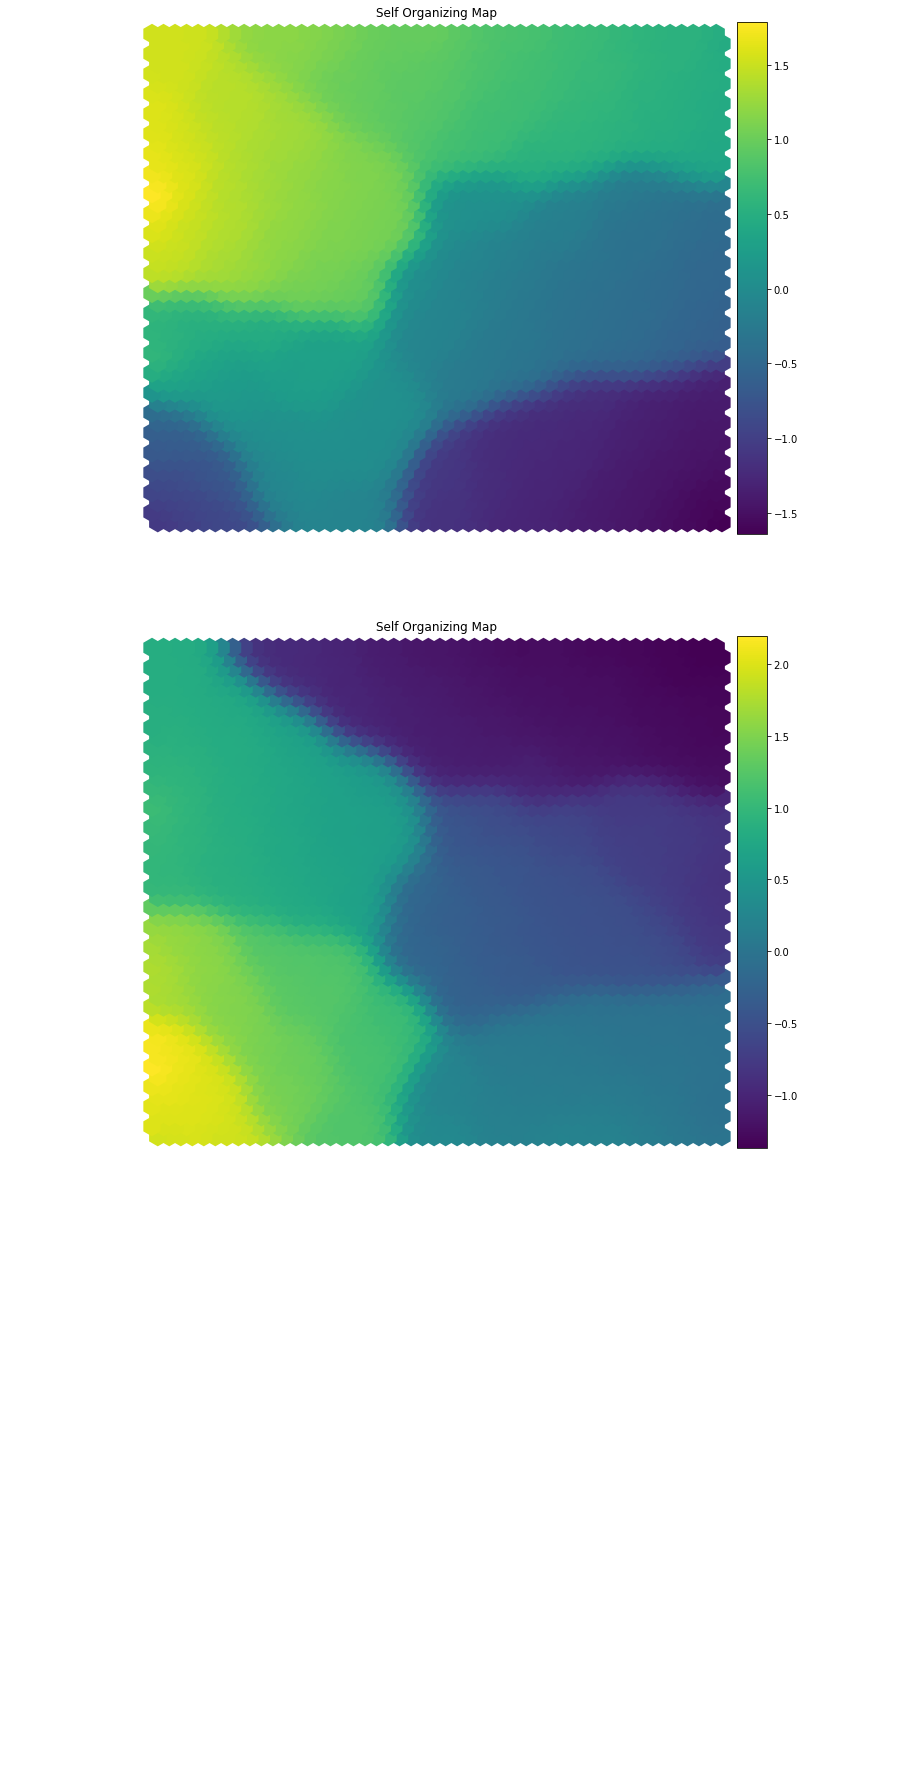

In [148]:
from sompy.visualization.mapview import View2D
view2D  = View2D(5,5,"",text_size=10)
view2D.show(sm, col_sz= 1, which_dim="all", denormalize=False)